## Denver Model
The notebook is to forecast number of house sales and listings in Denver months ahead with stacking models of Time series, Google Trends, and Economics Indicators.

In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pytrends.request import TrendReq
import pylab as pl
import sklearn
from sklearn.linear_model import LinearRegression, Lasso, LassoCV,RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
import preprocessing
from preprocessing import preprocessingMLS, featureEngineering
from getGoogleTrends import getGoogleTrendsData
import models
from models import baseModel, linearModel, rollingModel
from imp import reload
import matplotlib.ticker as ticker

In [164]:
reload(models)
reload(preprocessing)

<module 'preprocessing' from '/Users/diyixuan/Course/capstone/preprocessing.py'>

### 12.5 Update

1. Modularize the process
    - MLS preprocessing
    - google trends acquirement
    - Feature Engineering
    - Models: train-test, cross validation, nested cross validation
    
    
2. Overall prediction models stacking (Time series, Google trends, Economics)
    - Single model with google trends and economics features (not used)
    - **Linear Combination of Time Series prediction and Google Trends model (used)**
    - **Boosting with Economics data (used)**
    - Time series model using other features (not used)
    - **Predict 6 months ahead: Predict 3 months ahead with stacking model, and another 3 months ahead using time series**

In [32]:
process1 = preprocessingMLS('data/denver_listing_dates.csv')
monthData1 = process1.get_monthly_data(columns=['count_sale','count_list','sale_price'],start_date='2016-03', end_date='2020-09')


In [3]:
#get monthly data of number of listings, number of sales, and sales price
process = preprocessingMLS('denver_listing_dates_with_ct.csv')
monthData = process.get_monthly_data(columns=['count_sale','count_list','sale_price'],start_date='2016-03', end_date='2020-09')


In [4]:
#get google trends data from API
#----------------------------------------------------
#gt = getGoogleTrendsData(geo='US-GA',city='Atlanta')
#trend = gt.getData(times=10,date='2016-03-01 2020-09-30',scaled=True)
#trend.to_csv('google_trends_atlanta_scaled.csv')
#----------------------------------------------------
trend = pd.read_csv('google_trends_scaled.csv')

In [25]:
#get economics indicator features
econ = pd.read_csv('econ_data.csv')
#econ.head()

In [142]:
#merge three dataframes
merged = pd.merge(monthData, trend).drop(['Unnamed: 0'],axis=1)
#merged = pd.merge(merged,econ,how='left')
#merged.head()

In [143]:
#create lag features and one hot month features with featureEngineering
feature_column_names = merged.columns.delete(0)
fe = preprocessing.featureEngineering(merged,feature_column_names)
fe.create_lag_features(lag_num_list=[1,3])
fe.create_pct_change_features(lag_num_list=[1])
fe.create_month_one_hot()
df = fe.get_dataFrame()
feature_column_names = fe.get_feature_names()
print(len(feature_column_names))

136


## 1. Predicting number of sales
### 1.1 train-test &  cross validation

In [144]:
target_col = 'count_sale'
horizon = 3
model = models.linearModel(df,horizon,target_col,feature_column_names)
train_X_std, test_X_std, train_y, test_y = model.get_train_test(test_size=0.4)
model.fit(train_X_std, train_y, standardise=True)
rst, y_pred_train, y_pred_test = model.model_preformance(train_X_std, test_X_std, train_y, test_y,'count_sale_target')

In [145]:
rst

{'r2_train': 0.9930561269475927,
 'r2_test': 0.4307391172056633,
 'mse_train': 14307.178495366297,
 'mse_test': 2343534.078949485,
 'cv_score': 72553.55523311449}

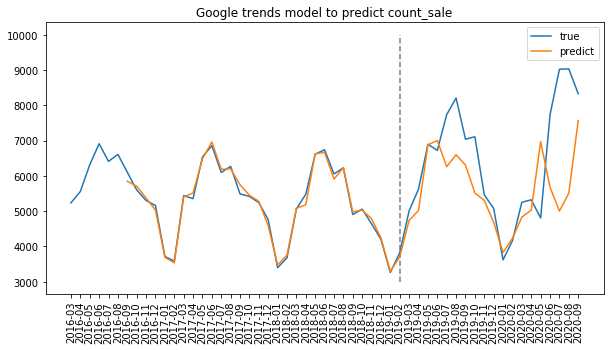

In [146]:
length_train = len(y_pred_train)
length_test = len(y_pred_test)
plt.figure(figsize=(10,5))
plt.plot(df.month, df[target_col],label='true')
plt.plot(df.month.iloc[horizon+3:],np.append(y_pred_train, y_pred_test)+df[target_col].iloc[-length_train-length_test-horizon:-horizon],label='predict')
plt.vlines(df.month.values[-length_test],ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Google trends model to predict '+target_col)
plt.xticks(rotation=90)
plt.legend()

In [147]:
model.selected_features

array(['count_sale', 'best realtors', 'townhomes for sale_lag3',
       'selling a house_lag3', 'zillow_lag3', 'real estate agents_lag3',
       'best realtors_lag1', 'redfin_lag3', 'realtor.com_lag3',
       'Homes near me_pct1', 'how much is my house_pct1', '02m', '10m',
       '11m', '12m'], dtype=object)

In [148]:
#most 5 important features in google trends model
#print(model.model.coef_)
print(model.selected_features[(-abs(model.model.coef_)).argsort()][:5])

['count_sale' '10m' 'zillow_lag3' 'redfin_lag3' 'realtor.com_lag3']


### 1.2 nested cross validation performance


In [171]:
reload(models)

<module 'models' from '/Users/diyixuan/Course/capstone/models.py'>

In [206]:
horizon = 3
target_col = 'count_sale'
r = models.rollingModel(df,horizon,target_col,feature_column_names)
end_predict_group = int(np.ceil(len(df)//horizon))
start_predict_group = 4
preds_google, std_google =  r.rolling_prediction(start_predict_group,end_predict_group,horizon)


prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3339.2567056712946, tolerance: 999.6422181818182
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2374.1506644571864, tolerance: 1061.3310181818183
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2270.8559742816383, tolerance: 1214.215090909091
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2143.8455795817454, tolerance: 770.2064727272725
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2937.446061005202, tolerance: 782.0412727272728
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1561.8110280107558, tolerance: 677.8902909090908
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3063.619760856775, tolerance: 1331.4872500000001
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6422.954212782402, tolerance: 1868.7692399999999
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3297.281133157141, tolerance: 1304.5109600000003
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4259.78535224185, tolerance: 1444.3862000000001
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4665.504702298147, tolerance: 1361.35849
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4273.601354858323, tolerance: 1524.50725
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5526.812845199311, tolerance: 3667.2372
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6118.873823383184, tolerance: 2615.3924
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8654.085230099106, tolerance: 3003.0263555555557
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of 

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8277.365441468428, tolerance: 2425.8822
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3394.454558155143, tolerance: 1110.5591555555557
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2644.0606183300824, tolerance: 1493.174488888889
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the n

prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2393.646294579237, tolerance: 1147.7757714285717
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 593.0118355841272, tolerance: 275.54428571428576
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3477.024745521861, tolerance: 1279.0173714285716
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2731.5980124432017, tolerance: 1084.6534357142855
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1086.7654802175625, tolerance: 640.4854928571428
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4992.147537866595, tolerance: 1351.02995
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4870.124125267673, tolerance: 1705.301907692308
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2137.9220318725907, tolerance: 1174.2343230769236
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3794.8375756637624, tolerance: 1669.2329230769233
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1668.9854030142562, tolerance: 1227.7566923076922
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3338.6600374886516, tolerance: 1329.6646
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5432.2747669513055, tolerance: 1632.8169076923077
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase th

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4790.6832105554395, tolerance: 1745.9342916666665
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12677.618466264286, tolerance: 3596.0317666666674
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6798.242015533231, tolerance: 2393.1338
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14170.998390298386, tolerance: 4788.4842
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7670.087041143118, tolerance: 1512.4896250000002
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4663.040381534427, tolerance: 2513.9362916666664
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the 

prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1890.7709744239103, tolerance: 977.0371529411765
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1011.9567829220834, tolerance: 646.7169529411764
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3863.587000507565, tolerance: 1406.5760470588234
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4372.173524652703, tolerance: 1361.6961058823529
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1918.975004017918, tolerance: 834.5633764705881
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2517.4787192850686, tolerance: 1250.9050117647057
  positive)


prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4663.776140751504, tolerance: 2485.206775
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6911.443187179105, tolerance: 2382.0395750000002
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3179.2581568859596, tolerance: 1695.555575
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2006.0600625480452, tolerance: 1074.3173000000002
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5592.686780379452, tolerance: 1935.90504375
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6448.750063501682, tolerance: 1176.64029375
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the n

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3310.5183346891718, tolerance: 2692.5668
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5002.906094002184, tolerance: 1551.3828933333334
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5001.254075310408, tolerance: 1583.9224933333335
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the 

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3978.8650246801553, tolerance: 3011.45304
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13745.975673908379, tolerance: 2862.9301333333333
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5623.28203246595, tolerance: 2527.1516933333337
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the

prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1072.4580724388943, tolerance: 906.9174437500001
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3123.162209592067, tolerance: 1084.905095
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 369.0759225489455, tolerance: 367.22764375
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5232.486849248352, tolerance: 1670.588055
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2809.5240688946456, tolerance: 967.2578799999999
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2444.244594449627, tolerance: 1483.731455
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2269.1184811504318, tolerance: 2122.602473684211
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4832.808913275534, tolerance: 2120.94045263158
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5175.516234551765, tolerance: 1562.5603157894736
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6165.310132165136, tolerance: 2650.2096
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3281.6888157217513, tolerance: 1348.6552421052631
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3274.5147961031334, tolerance: 2179.761852631579
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the 

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11012.725601438915, tolerance: 3043.4848944444448
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7410.882349419324, tolerance: 3719.3299611111115
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3717.297797469193, tolerance: 1312.4414000000002
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12686.530520132314, tolerance: 3450.79
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11383.843631471278, tolerance: 4316.073650000001
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14950.662785704484, tolerance: 3291.8520277777784
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the n

prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4316.245396798657, tolerance: 1580.8962956521739
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2571.8361341462396, tolerance: 1287.5906956521742
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2610.323420361332, tolerance: 1136.8233652173913
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4522.6101864707025, tolerance: 2752.028636363637
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3117.66159323938, tolerance: 2166.1343090909095
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13167.654880742768, tolerance: 4615.723236363636
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5981.639690311384, tolerance: 2775.0126772727276
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6828.544697153518, tolerance: 2959.158709090909
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9901.113864495364, tolerance: 2533.2679318181818
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13092.17471336579, tolerance: 5459.0188
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20541.195161258092, tolerance: 6805.778495238096
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8253.865460176192, tolerance: 3637.1030666666675
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the n

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15363.222325208379, tolerance: 5474.838495238095
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6170.839990326479, tolerance: 4062.669257142857
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11221.802218241573, tolerance: 6296.1324571428595
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 909.1786527843215, tolerance: 862.7106952380952
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2273.4739012127434, tolerance: 1108.5344653846155
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3709.2566919493192, tolerance: 1817.0815115384617
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4437.548051279042, tolerance: 1525.6862346153846
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5835.566139584285, tolerance: 1924.8265884615384
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5107.613858467106, tolerance: 1367.1084
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the n

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6189.200972261729, tolerance: 3849.797543999999
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13047.195855526325, tolerance: 4175.614504
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8297.192244426084, tolerance: 3815.034744
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8294.033413230745, tolerance: 2835.785103999999
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16142.851593728747, tolerance: 3799.4705440000007
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13681.929463174843, tolerance: 3441.7628
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the 

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9245.331398132164, tolerance: 2844.4062625
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8394.03097988165, tolerance: 4789.207195833333
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5893.782000122182, tolerance: 4324.364783333333
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the n

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10487.902467907496, tolerance: 4608.684
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9751.978489353683, tolerance: 5343.1839333333355
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7415.969242111887, tolerance: 3328.80425
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of

prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7856.256816058078, tolerance: 2534.2345793103445
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1377.8824995024988, tolerance: 943.1589241379313
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2523.641355959157, tolerance: 1232.542275862069
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13678.656834014673, tolerance: 3614.9812714285713
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6492.505718354254, tolerance: 3497.210810714286
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9088.297131398012, tolerance: 3216.140610714286
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4628.2464316370215, tolerance: 3860.9174107142867
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10512.894917888407, tolerance: 2627.8274678571424
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13246.893787984547, tolerance: 4836.170896428571
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to inc

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7867.830812840257, tolerance: 6051.638696296296
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12174.314296948216, tolerance: 7554.0828740740735
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8148.478547856123, tolerance: 4968.022785185185
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8512.814869059597, tolerance: 2297.9991875
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9536.280808098021, tolerance: 2070.2731875
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8256.19591731425, tolerance: 2122.42575
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6442.316147717196, tolerance: 3814.7832193548384
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16558.64080644845, tolerance: 3860.840367741935
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15152.293063001965, tolerance: 3782.8092
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the n

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4602.34596248613, tolerance: 2196.1295096774184
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8943.299756385037, tolerance: 3764.981967741937
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8814.708511143665, tolerance: 2495.561819354839
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15568.90796632994, tolerance: 6577.77328
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8321.17794596096, tolerance: 5545.003080000002
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10460.826579199915, tolerance: 6148.454216666668
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9310.211606882482, tolerance: 4076.2540166666668
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14361.669718969146, tolerance: 3667.6086700000005
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31844.11455744926, tolerance: 6065.147696666667
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6802.040370664199, tolerance: 2118.0328742857146
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5136.9844740972185, tolerance: 2010.0877600000003
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5529.684397661512, tolerance: 2366.4921142857143
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3862.278036226576, tolerance: 2166.5405885714285
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9306.553148490424, tolerance: 2441.4764685714285
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5133.382421844398, tolerance: 2118.1806742857143
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10349.575317877156, tolerance: 5346.122097058824
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5759.554024006531, tolerance: 3339.663247058824
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13001.247554143267, tolerance: 4559.271461764707
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6262.194464290873, tolerance: 5890.5509764705885
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18647.554677630913, tolerance: 3818.212002941177
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23184.684019848424, tolerance: 4264.874202941177
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26772.474639580792, tolerance: 8855.972187878788
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22503.251586904626, tolerance: 5887.384090909091
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32932.194116946564, tolerance: 9462.170606060607
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8723.624464999415, tolerance: 5117.0462242424255
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32132.478158809852, tolerance: 9331.286496969697
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21782.864269799913, tolerance: 5528.138351515152
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9844.859339094724, tolerance: 2762.3575473684214
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3129.831848240923, tolerance: 2841.1679466666665
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3023.59520441771, tolerance: 2841.1679466666665
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11856.330416154242, tolerance: 5173.806497297299
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16543.43713271676, tolerance: 4519.542118918917
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14276.981677037847, tolerance: 4063.628972972973
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37724.31884763297, tolerance: 7537.683588888888
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32627.733386786087, tolerance: 8441.657763888888
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33300.87610316291, tolerance: 10439.98856388889
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22229.42795877426, tolerance: 7642.119475
  positive)


prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7479.806769558293, tolerance: 3304.7891560975613
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6968.6699261516, tolerance: 1993.4418048780487
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12324.342776995729, tolerance: 2332.013687804878
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19133.62904309835, tolerance: 5544.547790000002
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15371.823931302253, tolerance: 5005.947177500002
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18584.7058901087, tolerance: 5576.90779
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the nu

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26701.629206692603, tolerance: 5818.49815
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10951.79745062433, tolerance: 5612.6740375
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20723.5874913626, tolerance: 3491.813077500001
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number 

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14694.19589130208, tolerance: 7705.110758974361
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27435.708371750112, tolerance: 8361.045343589743
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15508.151678862047, tolerance: 10177.12478974359
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26470.426619328537, tolerance: 3715.0404909090907
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2095.76727773482, tolerance: 1946.1392685714286
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2202.6901127207093, tolerance: 1946.1392685714286
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3066.527158331577, tolerance: 2495.761443181819
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4776.7097423557425, tolerance: 4055.230243181818
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5342.804419257668, tolerance: 1656.785672727273
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13806.696301292013, tolerance: 5878.577404651164
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21703.919805332775, tolerance: 7368.218311627908
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13791.943972669573, tolerance: 6255.700906976744
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31905.685130915837, tolerance: 11984.357983333333
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16470.727792365902, tolerance: 12560.412561904763
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31171.79446887403, tolerance: 9098.32307857143
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6977.616400571958, tolerance: 3877.74124680851
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19651.255398844423, tolerance: 4104.983148936171
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15324.310165039084, tolerance: 2939.765374468085
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23977.879693217732, tolerance: 5568.98195
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27701.46866191989, tolerance: 7574.283741304347
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19893.957087471055, tolerance: 8106.974480434783
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the 

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26745.958469612815, tolerance: 8268.34505777778
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28496.74329250914, tolerance: 10941.104657777776
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29707.782441801835, tolerance: 9778.312080000002
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3291.781321132614, tolerance: 3241.7101375
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3341.148953450087, tolerance: 3241.7101375
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3310.161933253854, tolerance: 3241.7101375
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of 

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36616.21339690837, tolerance: 9903.586355102041
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30109.467663504918, tolerance: 7060.131926530612
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26907.488559403842, tolerance: 15047.190881632654
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56840.95768350056, tolerance: 15895.03688125
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16993.425957435495, tolerance: 12433.694697916668
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47437.05423550772, tolerance: 14325.60159166667
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase 

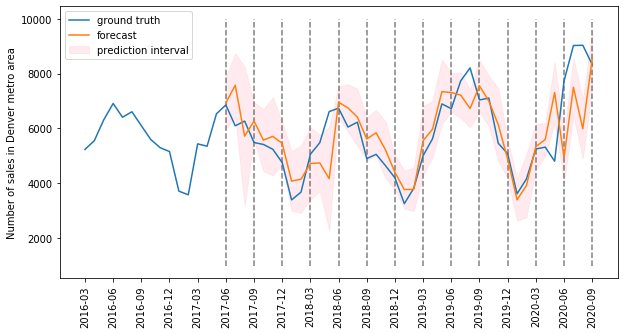

In [173]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(df.month, df[target_col],label='ground truth')
preds_month = df.month.iloc[r.split_idx[start_predict_group]:]
ticker_spacing = preds_month
ticker_spacing = 3
ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
plt.plot(preds_month,preds_google[:len(preds_month)],label='forecast')
plt.fill_between(preds_month, np.array(preds_google[:len(preds_month)])-2*np.array(std_google[:len(preds_month)]),
                 np.array(preds_google[:len(preds_month)])+2*np.array(std_google[:len(preds_month)]),
                 color='pink', alpha=0.3, label='prediction interval' )
plt.vlines(df.month[r.split_idx[start_predict_group:]],ymin=1000, ymax=10000,alpha=0.5,linestyle='--')
plt.ylabel('Number of sales in Denver metro area')
plt.xticks(rotation=90)
plt.legend()

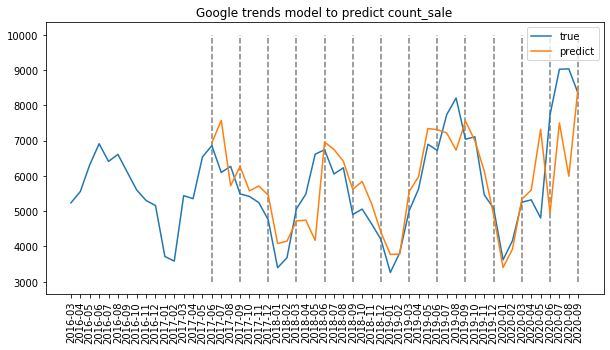

In [150]:
#plot
plt.figure(figsize=(10,5))
plt.plot(df.month, df[target_col],label='true')
preds_month = df.month.iloc[r.split_idx[start_predict_group]:]
plt.plot(preds_month,preds_google[:len(preds_month)],label='predict')
plt.vlines(df.month[r.split_idx[start_predict_group:]],ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Google trends model to predict '+target_col)
plt.xticks(rotation=90)
plt.legend()

In [151]:
mean_squared_error(df[target_col][-len(preds_month):],preds_google[:len(preds_month)])

1087177.7810151612

In [207]:
mean_absolute_error(df[target_col][-len(preds_month):],preds_google[:len(preds_month)])

1688.2122547318484

### 1.3 Time Series Model



In [138]:
'''
#for debug: simple predict model
sales = monthData['count_sale'].values.astype(float)
lists = monthData['count_list'].values.astype(float)
bmodel = models.BTSM()
bmodel.fit(sales,0)
pred_sales,scales, samples = bmodel.predict(np.ones(3))
'''

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Previously, `initial_step` would return the value passed to the constructor, even if that value was not `Tensor`-like. This behavior is now deprecated. In the future, it will always return a `Tensor`-like object.
Instructions for updating:
The signature for `trace_fn`s passed to `minimize` has changed. Trace functions now take a single `traceable_quantities` argument, which is a `tfp.math.MinimizeTraceableQuantities` namedtuple containing `traceable_quantities.loss`, `traceable_quantities.gradients`, etc. Please update your `trace_

In [152]:
horizon = 3
target_col = 'count_sale'
tsmodel = models.rollingTimeSeriesModel(df,horizon,target_col)
end_predict_group = int(np.ceil(len(df)//horizon))
start_predict_group = 4
preds_ts, scores_ts, preds_scale_ts = tsmodel.rolling_prediction(start_predict_group,end_predict_group)

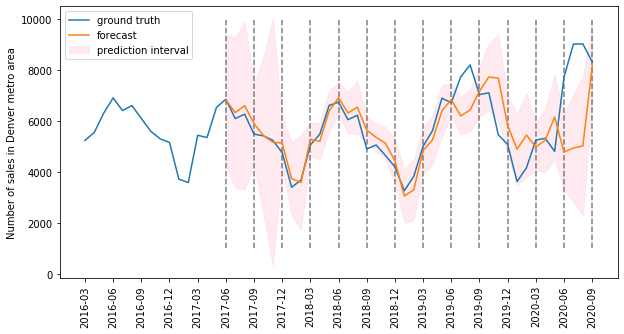

In [154]:
#plot: time series 3 months ahead
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(df.month, df[target_col],label='ground truth')
preds_month = df.month.iloc[r.split_idx[start_predict_group]:]
ticker_spacing = preds_month
ticker_spacing = 3
ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
plt.plot(preds_month,preds_ts[:len(preds_month)],label='forecast')
plt.fill_between(preds_month, np.array(preds_ts[:len(preds_month)])-2*np.array(preds_scale_ts[:len(preds_month)]),
                 np.array(preds_ts[:len(preds_month)])+2*np.array(preds_scale_ts[:len(preds_month)]),
                 color='pink', alpha=0.3, label='prediction interval' )
plt.vlines(df.month[r.split_idx[start_predict_group:]],ymin=1000, ymax=10000,alpha=0.5,linestyle='--')
plt.ylabel('Number of sales in Denver metro area')
plt.xticks(rotation=90)
plt.legend()

In [155]:
mean_squared_error(df[target_col][-len(preds_month):],preds_ts[:len(preds_month)])

1516827.0552359407

### 1.4 Linear Combination of Time Series and Google Trends, Boosting with Economics


In [160]:
# Linear Combination
preds_target = df[target_col].iloc[r.split_idx[start_predict_group]:]
lr = LinearRegression()
lr.fit(np.vstack((preds_google, preds_ts))[:,:len(preds_month)].T, preds_target)
intercept = lr.intercept_
coef = lr.coef_
print(lr.coef_)
print(lr.intercept_)

[ 1.3243606  -0.41027107]
290.8111242646992


In [180]:
#boosting
#residual error
preds_com = lr.predict(np.vstack((preds_google, preds_ts))[:,:len(preds_month)].T)
resid = preds_target - lr.predict(np.vstack((preds_google, preds_ts))[:,:len(preds_month)].T)


In [181]:
#create lag features and one hot month features with featureEngineering
econ = pd.read_csv('econ_data.csv')
econ_feature_column_names = econ.columns.delete(0)
fe = preprocessing.featureEngineering(econ,econ_feature_column_names)
fe.create_lag_features(lag_num_list=[1,2,3])
#fe.create_pct_change_features(lag_num_list=[1,2,3])
#fe.create_month_one_hot()
econ_df = fe.get_dataFrame()
econ_feature_column_names = fe.get_feature_names()
print(len(econ_feature_column_names))


84


In [182]:
#create data set in economics model
econ_sub = econ_df.iloc[-len(preds_month):,:]
econ_feature_column_names = econ_sub.columns[1:]
econ_sub['residual'] = resid.values

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [221]:
reload(models)

<module 'models' from '/Users/diyixuan/Course/capstone/models.py'>

In [222]:
r_econ = models.rollingModel(econ_sub,horizon,'residual',econ_feature_column_names,modelName='tree',lead_target=False)
end_predict_group = int(np.ceil(len(econ_sub)//horizon))
start_predict_group = 4
preds_boost, scores_boost = r_econ.rolling_prediction(start_predict_group,end_predict_group,horizon)

start group 4
prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1467.712787375669, tolerance: 473.4829056728044
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2805.2952990832855, tolerance: 473.4829056728044
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6520.7328862082795, tolerance: 473.4829056728044
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 2
prediction_horizon 3
start group 5
prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 678.6846359916672, tolerance: 408.0526662678602
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1240.5566509942146, tolerance: 637.9921218886809
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3428.1849730523245, tolerance: 637.9921218886809
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2323.5558150649085, tolerance: 347.368178540008
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2197.7151902698497, tolerance: 347.368178540008
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2077.9162120202964, tolerance: 347.368178540008
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 965.0179934068583, tolerance: 602.4236500359801
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 753.3505286888394, tolerance: 602.4236500359801
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 758.4100096067014, tolerance: 602.4236500359801
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2549.5764720331863, tolerance: 599.2238924167186
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3505.8972671581723, tolerance: 599.2238924167186
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4158.224285107688, tolerance: 599.2238924167186
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 741.8623880892992, tolerance: 622.0214907861038
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 843.4176189005375, tolerance: 622.0214907861038
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 786.5594476425322, tolerance: 622.0214907861038
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase

start group 6
prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 376.89667871320853, tolerance: 301.16404550519917
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1692.3659852879937, tolerance: 301.16404550519917
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4411.116320619534, tolerance: 301.16404550519917
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to inc

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2980.4874624942604, tolerance: 580.6084398756552
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6479.032891918076, tolerance: 580.6084398756552
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7282.655413438406, tolerance: 580.6084398756552
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 713.5948647490586, tolerance: 621.8507485046139
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1207.3782469946018, tolerance: 621.8507485046139
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1302.519283389498, tolerance: 621.8507485046139
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2256.043748821714, tolerance: 698.1076562875454
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1710.9563114045304, tolerance: 698.1076562875454
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1649.2410956851672, tolerance: 698.1076562875454
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 683.7730881588068, tolerance: 638.3069235609709
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1018.679361217597, tolerance: 638.3069235609709
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1064.4316070027126, tolerance: 638.3069235609709
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

start group 7
prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10356.099332684942, tolerance: 510.4009445474789
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12201.826314645179, tolerance: 510.4009445474789
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12117.232586703904, tolerance: 510.4009445474789
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13724.7588856199, tolerance: 747.0192514516666
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11306.610579424712, tolerance: 747.0192514516666
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8937.902902200643, tolerance: 747.0192514516666
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1022.3974520538177, tolerance: 750.946484309534
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1453.1794518449751, tolerance: 750.946484309534
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1396.4467624979734, tolerance: 750.946484309534
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 456.31151154125837, tolerance: 454.43814646827644
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2669.7153046487947, tolerance: 644.8166795559913
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5737.52303581874, tolerance: 644.8166795559913
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2464.3791913948953, tolerance: 621.9609281952364
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3050.5495487116714, tolerance: 621.9609281952364
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3753.340829123961, tolerance: 621.9609281952364
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1099.5427203543368, tolerance: 699.4018636651522
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2066.3605453579803, tolerance: 699.4018636651522
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2223.763385689119, tolerance: 699.4018636651522
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

start group 8
prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3255.609118336579, tolerance: 1027.158237369273
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1267.8157823530491, tolerance: 1027.158237369273
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1169.0541207559872, tolerance: 1027.158237369273
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11971.91110394083, tolerance: 1115.377415690954
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11298.820398234326, tolerance: 1115.377415690954
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6087.062383029814, tolerance: 1115.377415690954
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21390.38796816737, tolerance: 1295.1767030726628
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20716.13937529875, tolerance: 1295.1767030726628
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19091.458512490033, tolerance: 1295.1767030726628
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1389.8101598730718, tolerance: 1165.6255043858241
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1327.8403210299439, tolerance: 1165.6255043858241
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1241.1959801033372, tolerance: 1165.6255043858241
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to in

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1591.847682425112, tolerance: 1287.5853999452197
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8921.482532505092, tolerance: 1287.5853999452197
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24302.472770494816, tolerance: 1287.5853999452197
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1708.014638416702, tolerance: 1156.1969573403765
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1666.3201391217299, tolerance: 1156.1969573403765
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1591.6581433301326, tolerance: 1156.1969573403765
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to inc

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1793.7603070537734, tolerance: 1003.0421458954977
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2593.3735596875777, tolerance: 1003.0421458954977
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4485.667724484461, tolerance: 1003.0421458954977
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to inc

start group 9
prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74981.22101963614, tolerance: 1113.9778124903917
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105537.94175058906, tolerance: 1113.9778124903917
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 138535.06343946443, tolerance: 1113.9778124903917
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to inc

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17726.579302560887, tolerance: 1100.48763657613
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27812.904929976386, tolerance: 1100.48763657613
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36105.4558366125, tolerance: 1100.48763657613
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase t

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24610.705818414193, tolerance: 1260.0248171485598
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23501.997122932065, tolerance: 1260.0248171485598
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22395.017558838983, tolerance: 1260.0248171485598
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to in

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3115.7117507666117, tolerance: 1223.5766603123539
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3223.2397952798638, tolerance: 1223.5766603123539
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1910.378891308268, tolerance: 1223.5766603123539
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to inc

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1497.662638373673, tolerance: 1097.1798295354108
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2698.4315393455327, tolerance: 1097.1798295354108
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1501.5692197356839, tolerance: 1097.1798295354108
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to inc

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40308.02917879104, tolerance: 1249.5848372188027
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37943.034413582354, tolerance: 1249.5848372188027
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36166.6952508573, tolerance: 1249.5848372188027
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1417.2194781117141, tolerance: 1214.4653559153523
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1479.1766509530134, tolerance: 1214.4653559153523
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1507.8566732248291, tolerance: 1214.4653559153523
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to in

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10006.12796391797, tolerance: 969.7078606579502
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20643.65278252153, tolerance: 969.7078606579502
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37568.99949092392, tolerance: 969.7078606579502
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48240.74905097112, tolerance: 1106.2576840417323
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47366.01497955911, tolerance: 1106.2576840417323
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46543.61622414955, tolerance: 1106.2576840417323
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

start group 10
prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14810.76138607203, tolerance: 1294.6371242112918
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3421.4744237664854, tolerance: 1294.6371242112918
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2118.9264788678847, tolerance: 1294.6371242112918
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to inc

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 126813.29479001672, tolerance: 1106.1900255496623
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6392.825550573645, tolerance: 1271.9976523220882
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6271.086960092187, tolerance: 1271.9976523220882
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1718.8642485394084, tolerance: 933.6298913027213
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9285.355070701567, tolerance: 933.6298913027213
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10068.518732801953, tolerance: 933.6298913027213
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1354.1541306766449, tolerance: 1286.8057060110154
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1293.3699777623406, tolerance: 1286.8057060110154
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4188.281821827637, tolerance: 1286.8057060110154
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to inc

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1710.9399479321437, tolerance: 1406.5594096369625
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2893.460949945147, tolerance: 1406.5594096369625
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4372.011638326803, tolerance: 1406.5594096369625
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41966.88737803369, tolerance: 916.3335201608934
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43183.03903013369, tolerance: 916.3335201608934
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44300.977006042056, tolerance: 916.3335201608934
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1571.4928078544326, tolerance: 1057.4388817193017
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3349.6818707967177, tolerance: 1057.4388817193017
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4214.381089598872, tolerance: 1057.4388817193017
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to inc

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2498.6273843935924, tolerance: 872.2713163128192
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5354.469294797804, tolerance: 872.2713163128192
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14546.364939817577, tolerance: 872.2713163128192
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

start group 11
prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12212.447273548692, tolerance: 1641.9268055138384
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15667.778312625363, tolerance: 1641.9268055138384
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15793.854739695322, tolerance: 1641.9268055138384
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to in

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47224.85118563054, tolerance: 1334.8667464498967
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42107.809258621186, tolerance: 1334.8667464498967
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39636.670656170696, tolerance: 1334.8667464498967
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to inc

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56590.71831988613, tolerance: 1666.7704557109298
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85021.22424653778, tolerance: 1666.7704557109298
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91636.17660587886, tolerance: 1666.7704557109298
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5451.739979676902, tolerance: 1437.6697086602016
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12119.594590562163, tolerance: 1437.6697086602016
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16836.025105794193, tolerance: 1437.6697086602016
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to inc

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32931.05340578384, tolerance: 1378.150309152625
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34458.80098403321, tolerance: 1378.150309152625
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 75970.91617820674, tolerance: 1378.150309152625
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1813.9464060226455, tolerance: 1651.5857943224087
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4270.667709401809, tolerance: 1651.5857943224087
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8185.726120355539, tolerance: 1651.5857943224087
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1520.3746128221974, tolerance: 1265.9870389739729
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1420.2865609386936, tolerance: 1265.9870389739729
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1394.5466452958062, tolerance: 1265.9870389739729
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to in

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12902.341502732364, tolerance: 1426.375429358475
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16189.150147485314, tolerance: 1426.375429358475
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16901.16496103909, tolerance: 1426.375429358475
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13678.078353632474, tolerance: 1378.150309152625
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46204.097017532215, tolerance: 1378.150309152625
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56160.43901969516, tolerance: 1378.150309152625
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1851.782677039504, tolerance: 1507.6600035838378
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24011.241423733998, tolerance: 1507.6600035838378
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37850.77258592844, tolerance: 1507.6600035838378
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23206.706870216643, tolerance: 1600.3744332195733
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22295.526459676214, tolerance: 1600.3744332195733
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21250.605318812188, tolerance: 1600.3744332195733
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to in

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1483.4583502870519, tolerance: 1229.9688192841975
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1476.3847079715924, tolerance: 1229.9688192841975
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1458.2140262855683, tolerance: 1229.9688192841975
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to in

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1397.046649419237, tolerance: 1366.8672588810505
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1926.3597623149399, tolerance: 1366.8672588810505
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4191.927850143751, tolerance: 1366.8672588810505
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

start group 12
prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3525.4995778482407, tolerance: 2723.014974066097
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10461.601627334021, tolerance: 2723.014974066097
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18025.3970607901, tolerance: 2723.014974066097
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77890.3840193632, tolerance: 2422.3699249854385
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6164.826821437571, tolerance: 2695.7857579295583
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27411.13296015514, tolerance: 2695.7857579295583
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5917.678267341573, tolerance: 2525.595450974495
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5826.086015760899, tolerance: 2525.595450974495
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5692.465009112377, tolerance: 2525.595450974495
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12619.121063221246, tolerance: 2637.2070752715285
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77620.6389444964, tolerance: 2637.2070752715285
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134407.25266335625, tolerance: 2637.2070752715285
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80129.77092008432, tolerance: 2568.5965840970202
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 82442.44480076735, tolerance: 2568.5965840970202
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81768.69743904471, tolerance: 2568.5965840970202
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 131566.28344782256, tolerance: 2524.9158229649743
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175596.84663622873, tolerance: 2524.9158229649743
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 209476.26650286932, tolerance: 2524.9158229649743
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to in

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1794.0127883646637, tolerance: 1442.6579718005285
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1778.291944981087, tolerance: 1442.6579718005285
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11521.307242283598, tolerance: 1442.6579718005285
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to inc

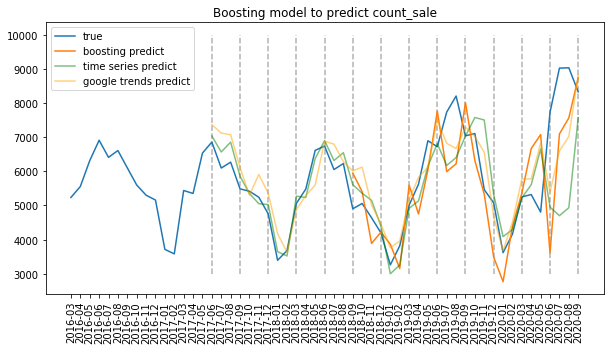

In [223]:
#plot
plt.figure(figsize=(10,5))
plt.plot(df.month, df[target_col],label='true')
start_predict_group = 4
preds_month_boost = econ_sub.month.iloc[r.split_idx[start_predict_group]:]
plt.plot(preds_month_boost,preds_boost[:len(preds_month_boost)]+preds_com[-len(preds_month_boost):],label='boosting predict')
plt.plot(preds_month,preds_ts[:len(preds_month)],label='time series predict',alpha=0.5,color='green')
plt.plot(preds_month,preds_google[:len(preds_month)],label='google trends predict',alpha=0.5,color='orange')
plt.vlines(df.month[r.split_idx[start_predict_group:]],ymin=3000, ymax=10000,alpha=0.3,linestyle='--')
plt.title('Boosting model to predict '+target_col)
plt.xticks(rotation=90)
plt.legend()

In [224]:
mean_squared_error(df[target_col][-len(preds_month_boost):],preds_boost[:len(preds_month_boost)]+preds_com[-len(preds_month_boost):])

1894676.539173587

### 1.5 Predict 6 months ahead

First use boosting model to predict 3 months ahead, then use time series model to predict next 3 months.

In [180]:
horizon = 6
target_col = 'count_sale'
r = models.rollingModel(df,horizon,target_col,feature_column_names)
end_predict_group = int(np.ceil(len(df)//horizon))
start_predict_group = 4
preds_google, std_google =  r.rolling_prediction(start_predict_group,end_predict_group,horizon)

prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1194.0932240975721, tolerance: 832.4526038461539
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6381.4152732041475, tolerance: 2363.12205
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2961.3615672566234, tolerance: 1133.7966461538463
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase th

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9190.81603774901, tolerance: 3506.7637999999993
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8026.219871044466, tolerance: 3738.9205040000006
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14800.206418584803, tolerance: 3252.1730960000004
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10963.284268812024, tolerance: 2305.7720560000002
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15645.544739179517, tolerance: 4204.087863999999
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7866.793533893762, tolerance: 3377.7607760000005
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4717.760568532354, tolerance: 4548.1368
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15845.261811901275, tolerance: 7137.350933333335
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17304.33209003989, tolerance: 5133.9801625
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number 

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6811.697015712547, tolerance: 4987.9924625
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21766.918939992316, tolerance: 7388.97365
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10317.380985404903, tolerance: 5605.905295833333
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

prediction_horizon 4


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7635.051362540706, tolerance: 6601.963886956523
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14765.514505418532, tolerance: 6274.89116521739
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15430.312757082056, tolerance: 8484.483643478261
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

prediction_horizon 5


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25320.156307695514, tolerance: 9101.19107727273
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12181.751412452659, tolerance: 6160.563527272728
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5554.360726894172, tolerance: 5334.6943272727285
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 6


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10084.804096388492, tolerance: 8379.86298095238
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17693.4372211139, tolerance: 7455.111266666668
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7190.57762027945, tolerance: 5140.663695238096
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase t

prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7554.168161229173, tolerance: 2351.5119875
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4103.851734167596, tolerance: 1423.0924875
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11469.855421701846, tolerance: 2204.005121875
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number 

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6442.316147717196, tolerance: 3814.7832193548384
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4715.883111508338, tolerance: 2113.8493548387096
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8038.834962860363, tolerance: 2724.1785741935482
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3629.324498767164, tolerance: 2882.6271741935484
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14842.732489472952, tolerance: 4377.709496774193
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8381.362886489182, tolerance: 3231.5288967741935
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16291.079011973789, tolerance: 3824.3237200000003
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15562.60114704852, tolerance: 4054.636736666667
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10676.143745445335, tolerance: 5466.990986666667
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7405.738475258026, tolerance: 5700.438586666667
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20631.97367608018, tolerance: 5735.387746666665
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13556.008949657727, tolerance: 7310.246336666668
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

prediction_horizon 4


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19389.78909485969, tolerance: 6479.790055172414
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11002.993754879068, tolerance: 7823.258068965519
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7715.085046062621, tolerance: 5617.33771724138
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12052.588047407084, tolerance: 7076.538324137931
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18368.36995001032, tolerance: 9585.292682758618
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9476.45120945253, tolerance: 7363.213068965518
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase

prediction_horizon 5


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10045.32187684907, tolerance: 6275.262810714285
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10790.499049500513, tolerance: 10481.661100000001
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14757.470238021471, tolerance: 6151.235085714286
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13007.009329064036, tolerance: 9158.366610714284
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10186.034946730291, tolerance: 8527.579896428571
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19272.54716738139, tolerance: 8171.270885714287
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 6


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16529.95875040904, tolerance: 7177.955999999999
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14130.99660304697, tolerance: 11636.93986666667
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11954.841862623318, tolerance: 9203.32031851852
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase

prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8698.713004267067, tolerance: 2395.536781578947
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2721.105757852478, tolerance: 1855.0768552631575
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2091.9850682143588, tolerance: 1897.0856300000003
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11933.633501669217, tolerance: 6084.905497297298
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14723.961754709919, tolerance: 5650.378691891892
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25104.877098200963, tolerance: 5224.217032432432
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18791.479129826817, tolerance: 5551.075972972973
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19931.986062464075, tolerance: 5082.855308108108
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6799.553585093396, tolerance: 5007.813027027028
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30445.61550570857, tolerance: 10103.613430555555
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20078.0534343833, tolerance: 8302.525275
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13400.83467175431, tolerance: 5831.44078888889
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the nu

prediction_horizon 4


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60446.18682575389, tolerance: 11874.077274285715
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34223.30322529652, tolerance: 13985.12026857143
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16681.649978627956, tolerance: 9045.604554285714
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 5


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14857.549555617034, tolerance: 12701.064861764706
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30409.54904217849, tolerance: 10827.799988235294
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23148.217236990455, tolerance: 12869.666438235294
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to inc

prediction_horizon 6


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25470.397234589, tolerance: 14159.352387878787
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22402.229232836366, tolerance: 15753.56745454546
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26656.91723323989, tolerance: 19395.8684969697
  positive)


prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10504.24381131599, tolerance: 3414.664515909091
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6248.74607996824, tolerance: 2931.8416727272734
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4870.291244822956, tolerance: 2715.8096431818176
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11874.858793474545, tolerance: 3451.567418181819
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12942.216642095227, tolerance: 3333.4342795454545
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6529.230794362626, tolerance: 1960.8303886363633
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28564.156401201184, tolerance: 5192.646860465117
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30611.601895507298, tolerance: 6379.147367441861
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20825.61521209397, tolerance: 5475.269762790697
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11437.673853254875, tolerance: 6376.701344186046
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12952.668036234889, tolerance: 8439.033186046512
  positive)


prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34043.964149816784, tolerance: 9598.993714285716
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37625.87655400476, tolerance: 10704.671361904764
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33752.50919857894, tolerance: 12961.982611904761
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

prediction_horizon 4


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33014.86768271723, tolerance: 12391.818039024394
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31871.02754618891, tolerance: 13896.106575609756
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38427.512974052865, tolerance: 16818.48836097561
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

prediction_horizon 5


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42974.55339842567, tolerance: 19969.72624
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53083.821319515875, tolerance: 15362.510960000003
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32256.69766789288, tolerance: 14129.37376
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

prediction_horizon 6


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48872.96592387789, tolerance: 21228.260107692313
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26655.02067615146, tolerance: 26448.0656
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34759.173190545596, tolerance: 19135.414174358975
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the

prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23115.4294076104, tolerance: 3164.2795380000002
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19194.15717827333, tolerance: 4574.040800000001
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10845.81860646134, tolerance: 3837.9646500000003
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4301.442631397238, tolerance: 2938.467712
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10155.674667750282, tolerance: 6016.5094500000005
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32310.059023475173, tolerance: 5104.037928000002
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase th

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25511.38682229334, tolerance: 7498.7297836734715
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 42784.89997469799, tolerance: 6751.970420408163
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25644.66294585791, tolerance: 9585.005926530612
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32409.790368901693, tolerance: 11019.00064791667
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 54665.60632391375, tolerance: 13571.63266666667
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26686.756230141807, tolerance: 16951.113631250002
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

prediction_horizon 4


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 65697.01721056277, tolerance: 17344.040123404255
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56650.155702300595, tolerance: 18796.69049787234
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 76231.74164961037, tolerance: 21858.5482
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the 

prediction_horizon 5


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147479.1162746731, tolerance: 33360.233541304355
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77446.51239753046, tolerance: 27586.77399130436
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53161.369638253505, tolerance: 19152.78217391304
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 6


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24841.227826086983, tolerance: 23172.45608
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43544.65013081345, tolerance: 32102.91557777778
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45090.58848479722, tolerance: 31076.58297777778
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the 

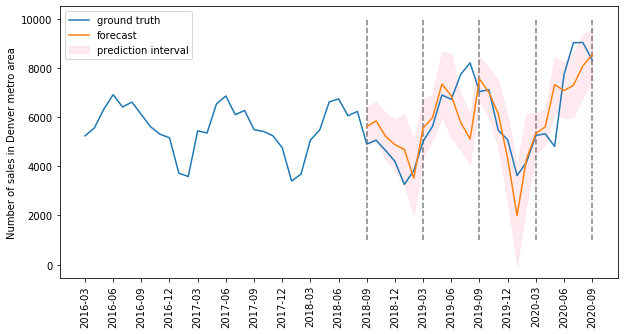

In [181]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(df.month, df[target_col],label='ground truth')
preds_month = df.month.iloc[r.split_idx[start_predict_group]:]
ticker_spacing = preds_month
ticker_spacing = 3
ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
plt.plot(preds_month,preds_google[:len(preds_month)],label='forecast')
plt.fill_between(preds_month, np.array(preds_google[:len(preds_month)])-2*np.array(std_google[:len(preds_month)]),
                 np.array(preds_google[:len(preds_month)])+2*np.array(std_google[:len(preds_month)]),
                 color='pink', alpha=0.3, label='prediction interval' )
plt.vlines(df.month[r.split_idx[start_predict_group:]],ymin=1000, ymax=10000,alpha=0.5,linestyle='--')
plt.ylabel('Number of sales in Denver metro area')
plt.xticks(rotation=90)
plt.legend()

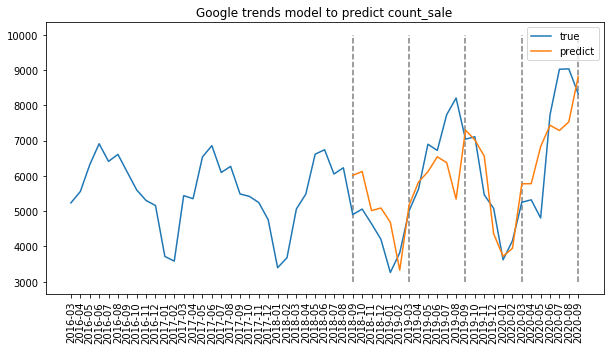

In [17]:
#plot
plt.figure(figsize=(10,5))
plt.plot(df.month, df[target_col],label='true')
preds_month = df.month.iloc[r.split_idx[start_predict_group]:]
plt.plot(preds_month,preds_google[:len(preds_month)],label='predict')
plt.vlines(df.month[r.split_idx[start_predict_group:]],ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Google trends model to predict '+target_col)
plt.xticks(rotation=90)
plt.legend()

In [18]:
mean_squared_error(df[target_col][-len(preds_month):],preds_google[:len(preds_month)])

1132934.7202826636

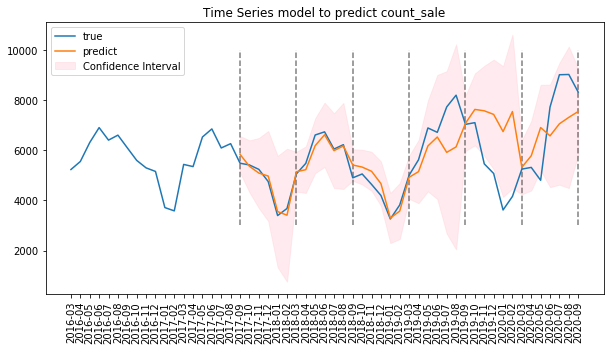

In [229]:
#plot
plt.figure(figsize=(10,5))
plt.plot(df.month, df[target_col],label='true')
preds_month = df.month.iloc[r.split_idx[start_predict_group]:]
plt.plot(preds_month,preds_ts[:len(preds_month)],label='predict')
plt.fill_between(preds_month, np.array(preds_ts[:len(preds_month)])-2*np.array(preds_scale_ts[:len(preds_month)]),
                 np.array(preds_ts[:len(preds_month)])+2*np.array(preds_scale_ts[:len(preds_month)]),
                 color='pink', alpha=0.3, label='Confidence Interval' )
plt.vlines(df.month[r.split_idx[start_predict_group:]],ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Time Series model to predict '+target_col)
plt.xticks(rotation=90)
plt.legend()

In [230]:
mean_squared_error(df[target_col][-len(preds_month):],preds_ts[:len(preds_month)])

1480029.3431734045

In [189]:
reload(models)

<module 'models' from '/Users/diyixuan/Course/capstone/models.py'>

In [198]:
horizon = 6
split = 3
target_col = 'count_sale'
model = models.rollingCombinedModel(df,horizon,split, feature_column_names, target_col)
end_predict_group = int(np.ceil(len(df)//horizon))
start_predict_group = 4
preds, preds_scale, preds_samples = model.rolling_prediction(start_predict_group,end_predict_group)

prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2989.861428147635, tolerance: 1329.399261538462
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2098.570185185882, tolerance: 1116.5774653846154
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4695.676125531448, tolerance: 1454.28585
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the n

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2659.802987935417, tolerance: 1773.090415384615
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2040.4384902108386, tolerance: 1138.548953846154
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 930.1625030302812, tolerance: 865.1346000000001
  positive)


prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6730.606839119709, tolerance: 2568.815744000001
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9998.058373050722, tolerance: 3673.7442160000014
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9086.27594175709, tolerance: 3024.965936
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the n

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5211.061817610995, tolerance: 3045.1342560000003
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13202.66976669625, tolerance: 4190.285999999999
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7717.588945566891, tolerance: 3177.7285040000006
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4494.490677634327, tolerance: 4455.189183333334
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11558.621552488621, tolerance: 3988.891783333333
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11527.18964414193, tolerance: 4766.5626625
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14199.714555527731, tolerance: 4459.0704625
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15565.415544353407, tolerance: 5935.4365333333335
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8853.915640878919, tolerance: 4804.306895833334
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase t

4


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6442.316147717196, tolerance: 3814.7832193548384
  positive)


prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9391.933222510914, tolerance: 2518.8974000000003
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10835.300774108355, tolerance: 2561.2467875
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7527.43128602457, tolerance: 1898.7694875000002
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase th

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6442.316147717196, tolerance: 3814.7832193548384
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12030.093513667724, tolerance: 4416.20497419355
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16087.089628745949, tolerance: 3891.5802387096774
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6800.857862601271, tolerance: 3612.8747354838706
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5620.55627654753, tolerance: 1860.3180193548385
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13674.017662085304, tolerance: 4126.676877419354
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14776.061743702354, tolerance: 4038.726496666667
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21593.72101379278, tolerance: 7650.285896666667
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4552.2474976464655, tolerance: 4169.91875
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the 

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9835.050815470255, tolerance: 5623.458736666667
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5949.714970345119, tolerance: 3195.6559366666665
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5692.846927411089, tolerance: 4091.4341866666664
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

5
prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8416.246591268884, tolerance: 3045.7196342105267
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5824.567325401777, tolerance: 2233.665989473684
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4318.623427657149, tolerance: 2741.997497368422
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8990.254419971046, tolerance: 2611.3928842105265
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9538.758192018387, tolerance: 2652.720339473685
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8360.867747659138, tolerance: 2835.4013815789485
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24830.782148429033, tolerance: 5127.4806108108105
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12514.380156738538, tolerance: 4477.331156756757
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14949.2374474975, tolerance: 5567.05118918919
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18330.44018137653, tolerance: 5669.0267297297305
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17178.87803742444, tolerance: 5383.04052972973
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8903.594610381, tolerance: 4259.741632432433
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase th

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32272.347762423302, tolerance: 8586.900497222223
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39593.255100088434, tolerance: 8255.88156388889
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35589.857320659, tolerance: 7787.429030555556
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase 

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16150.03323941234, tolerance: 4950.312763888889
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34649.80183385578, tolerance: 7583.779500000001
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27910.107367856468, tolerance: 6921.475430555555
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

6
prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12180.567897704725, tolerance: 3202.1383886363637
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2542.1665879300563, tolerance: 2359.61416
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2246.7887931898294, tolerance: 2134.846457142857
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase th

prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17801.464052695264, tolerance: 5773.778167441861
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7506.053209628233, tolerance: 5224.555604651164
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17143.654667772393, tolerance: 5562.970641860466
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increa

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43007.156920311405, tolerance: 9045.61624047619
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19276.780422650474, tolerance: 11338.402247619048
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53970.27660239452, tolerance: 14714.087278571431
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incre

7
prediction_horizon 1


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15794.848830204914, tolerance: 4531.278832000001
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15284.917803858538, tolerance: 4740.710192
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21234.024863736802, tolerance: 3563.91145
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the numbe

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19569.77295764953, tolerance: 5440.908087999999
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2411.6419014218554, tolerance: 2380.66795
  positive)


prediction_horizon 2


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44574.15216600405, tolerance: 9154.235853061224
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11134.16571967899, tolerance: 9721.925567346938
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24076.229246627947, tolerance: 9189.470195918368
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increas

prediction_horizon 3


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 58014.68103256583, tolerance: 16058.520591666667
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32489.349444755087, tolerance: 15399.134247916667
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36153.57841240003, tolerance: 13639.501797916666
  positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to incr

8


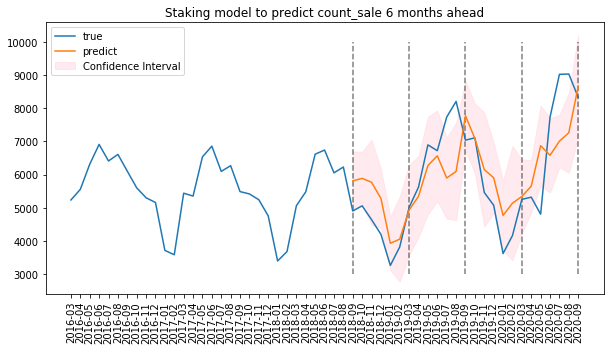

In [199]:
#plot
plt.figure(figsize=(10,5))
plt.plot(df.month, df[target_col],label='true')
preds_month = df.month.iloc[r.split_idx[start_predict_group]:]
plt.plot(preds_month,preds[:len(preds_month)],label='predict')
plt.fill_between(preds_month, np.array(preds[:len(preds_month)])-2.5*np.array(preds_scale[:len(preds_month)]),
                 np.array(preds[:len(preds_month)])+2.5*np.array(preds_scale[:len(preds_month)]),
                 color='pink', alpha=0.3, label='Confidence Interval' )
plt.vlines(df.month[r.split_idx[start_predict_group:]],ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Staking model to predict '+target_col+' 6 months ahead')
plt.xticks(rotation=90)
plt.legend()

In [200]:
mean_squared_error(df[target_col][-len(preds_month):],preds[:len(preds_month)])

1189270.9018419683

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(df.month, df[target_col],label='ground truth')
preds_month = df.month.iloc[r.split_idx[start_predict_group]:]
ticker_spacing = preds_month
ticker_spacing = 3
ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
plt.plot(preds_month,preds[:len(preds_month)],label='forecast')
plt.fill_between(preds_month, np.array(preds[:len(preds_month)])-2*np.array(preds_scale[:len(preds_month)]),
                 np.array(preds[:len(preds_month)])+2*np.array(preds_scale[:len(preds_month)]),
                 color='pink', alpha=0.3, label='prediction interval' )
plt.vlines(df.month[r.split_idx[start_predict_group:]],ymin=2000, ymax=10000,alpha=0.5,linestyle='--')
plt.ylabel('Number of sales in Denver metro area')
plt.xticks(rotation=90)
plt.legend()

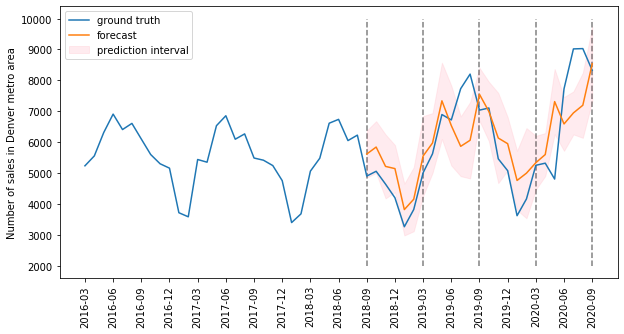

In [185]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(df.month, df[target_col],label='ground truth')
preds_month = df.month.iloc[r.split_idx[start_predict_group]:]
ticker_spacing = preds_month
ticker_spacing = 3
ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
plt.plot(preds_month,preds[:len(preds_month)],label='forecast')
plt.fill_between(preds_month, np.array(preds[:len(preds_month)])-2*np.array(preds_scale[:len(preds_month)]),
                 np.array(preds[:len(preds_month)])+2*np.array(preds_scale[:len(preds_month)]),
                 color='pink', alpha=0.3, label='prediction interval' )
plt.vlines(df.month[r.split_idx[start_predict_group:]],ymin=2000, ymax=10000,alpha=0.5,linestyle='--')
plt.ylabel('Number of sales in Denver metro area')
plt.xticks(rotation=90)
plt.legend()

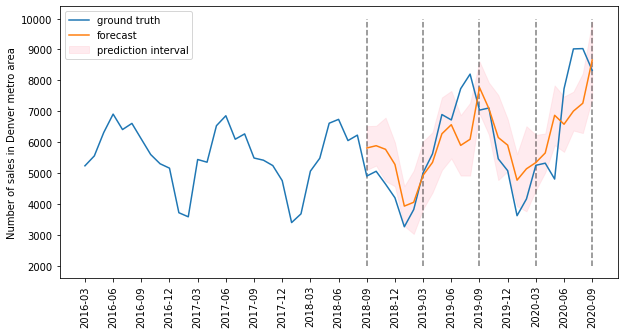

In [202]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(df.month, df[target_col],label='ground truth')
preds_month = df.month.iloc[r.split_idx[start_predict_group]:]
ticker_spacing = preds_month
ticker_spacing = 3
ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
plt.plot(preds_month,preds[:len(preds_month)],label='forecast')
plt.fill_between(preds_month, np.array(preds[:len(preds_month)])-2*np.array(preds_scale[:len(preds_month)]),
                 np.array(preds[:len(preds_month)])+2*np.array(preds_scale[:len(preds_month)]),
                 color='pink', alpha=0.3, label='prediction interval' )
plt.vlines(df.month[r.split_idx[start_predict_group:]],ymin=2000, ymax=10000,alpha=0.5,linestyle='--')
plt.ylabel('Number of sales in Denver metro area')
plt.xticks(rotation=90)
plt.legend()

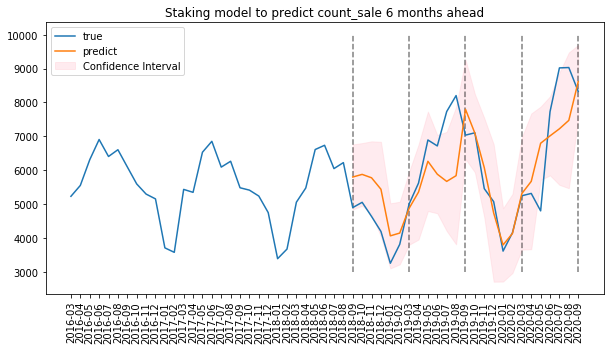

In [196]:
#plot
plt.figure(figsize=(10,5))
plt.plot(df.month, df[target_col],label='true')
preds_month = df.month.iloc[r.split_idx[start_predict_group]:]
plt.plot(preds_month,preds[:len(preds_month)],label='predict')
plt.fill_between(preds_month, np.array(preds[:len(preds_month)])-2*np.array(preds_scale[:len(preds_month)]),
                 np.array(preds[:len(preds_month)])+2*np.array(preds_scale[:len(preds_month)]),
                 color='pink', alpha=0.3, label='Confidence Interval' )
plt.vlines(df.month[r.split_idx[start_predict_group:]],ymin=3000, ymax=10000,alpha=0.5,linestyle='--')
plt.title('Staking model to predict '+target_col+' 6 months ahead')
plt.xticks(rotation=90)
plt.legend()

In [197]:
mean_squared_error(df[target_col][-len(preds_month):],preds[:len(preds_month)])

1101084.0093402464

In [205]:
mean_absolute_error(df[target_col][-len(preds_month):],preds[:len(preds_month)])

882.7774012733494